In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
import utils

In [3]:
import rompy as rp

In [4]:
from scrinet.greedy import greedyrb

## GPR imports

In [5]:
import pymc3 as pm

In [6]:
import arviz as az

In [7]:
import tensorflow as tf

In [8]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# match function

In [9]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)

    ts = ifft / h1h1 / h2h2 * 4 * dt
    m = np.max(np.abs(ts))

    return m

# load NR waveforms

In [10]:
import glob
import os

In [11]:
# get data
nrfiles_single_res = dict(
    q1="/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5",
    q2="/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5",
    q4="/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5",
    q5="/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5",
    q10="/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5",
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
)

In [12]:
def make_nr_dict():
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    root_dir = "/Users/spx8sk/work/data/"
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [13]:
nrfiles = make_nr_dict()

In [14]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [15]:
nrfiles_single_res

{'q1': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
 'q2': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
 'q4': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
 'q5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
 'q10': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
 'q18': '/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5'}

## example waveform generation

In [16]:
wg0 = utils.WaveformGeneration(nrfile=nrfiles_single_res["q18"])
wg1 = utils.WaveformGeneration(approximant=lalsim.SEOBNRv4, q=18)
wg2 = utils.WaveformGeneration(approximant=lalsim.IMRPhenomD, q=18)
wg3 = utils.WaveformGeneration(approximant=lalsim.IMRPhenomC, q=18)
wg4 = utils.WaveformGeneration(approximant=lalsim.IMRPhenomB, q=18)

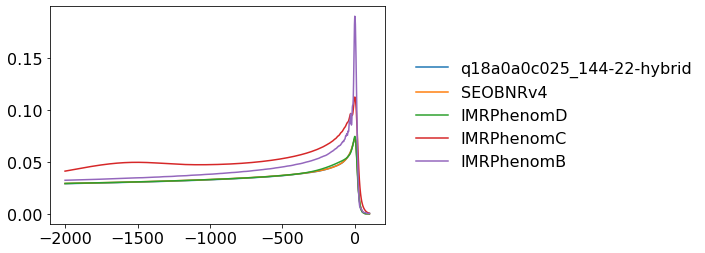

In [17]:
plt.figure()
for wg in [wg0, wg1, wg2, wg3, wg4]:
    plt.plot(wg.times, wg.amp, label=wg.label)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
# plt.xlim(-100,100)
# plt.yscale('log')

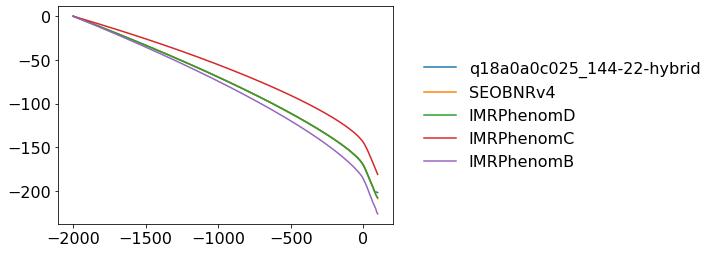

In [18]:
plt.figure()
for wg in [wg0, wg1, wg2, wg3, wg4]:
    plt.plot(wg.times, wg.phase, label=wg.label)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
# plt.xlim(-100,100)
# plt.yscale('log')

(-0.6, 0)

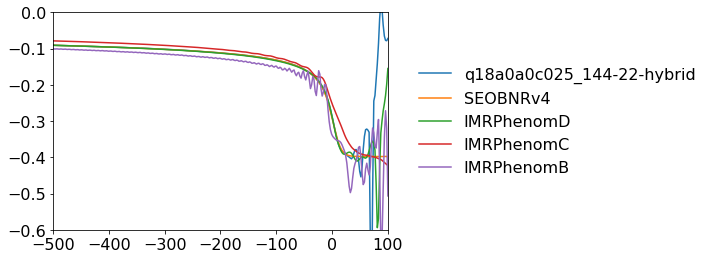

In [19]:
plt.figure()
for wg in [wg0, wg1, wg2, wg3, wg4]:
    plt.plot(wg.times, wg.freq, label=wg.label)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.xlim(-500,100)
plt.ylim(-0.6, 0)
# plt.yscale('log')

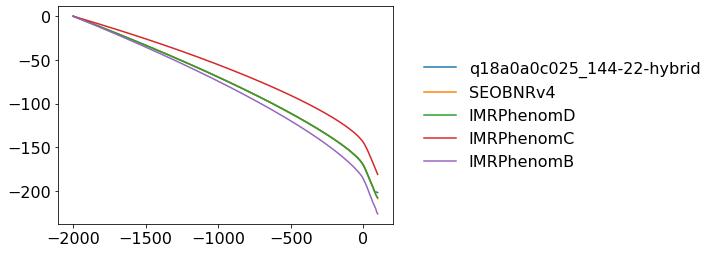

In [20]:
plt.figure()
for wg in [wg0, wg1, wg2, wg3, wg4]:
    plt.plot(wg.times, np.unwrap(np.angle(wg.h22)), label=wg.label)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

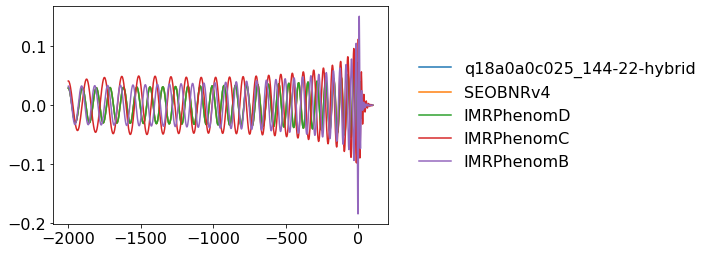

In [21]:
plt.figure()
for wg in [wg0, wg1, wg2, wg3, wg4]:
    plt.plot(wg.times, wg.Reh22, label=wg.label)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

# generate NR data

In [22]:
npts=1000

In [23]:
NR_wfs = [utils.WaveformGeneration(nrfile=nrfiles_single_res[key], npts=npts) for key in nrfiles_single_res]

In [24]:
nrfiles_single_res['q18']

'/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5'

In [25]:
# NR_wfs=[]
# for key in nrfiles.keys():
#     for skey in nrfiles[key].keys():
#         NR_wfs.append(utils.WaveformGeneration(nrfile=nrfiles[key][skey], npts=npts))
        
# NR_wfs.append(utils.WaveformGeneration(nrfile=nrfiles_single_res['q18'], npts=npts))

In [26]:
len(NR_wfs)

6

In [27]:
[NR.q for NR in NR_wfs]

[1.0, 2.0, 4.0, 5.0, 10.0, 18.0]

In [28]:
nr_q_arr = np.array([wg.q for wg in NR_wfs])

# generate modelA and modelB waveforms

In [29]:
q_min = 1
# max NR mass-ratio we have right now is 18
# q_max = 18
q_max = 19
# q_npts = 100
dq = 0.2

# dq=0.1
# q_random = np.random.uniform(q_min+dq, q_max-dq, q_npts)
# q_same_as_nr = np.array([1,2,4,5,10,18])
# q_arr = np.concatenate((q_same_as_nr, q_random))

# q_arr = np.linspace(q_min, q_max, q_npts)

q_arr = np.arange(q_min, q_max, dq)

In [30]:
q_arr.shape

(90,)

In [31]:
def gen_model_waveforms(approx, qlist, npts):
    lal_approx = lalsim.GetApproximantFromString(approx)
    return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts) for q in qlist]

In [32]:
wf_model_names = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomC", "IMRPhenomB"]
model_wfs = {}
for wf_model_name in wf_model_names:
    print(f"working {wf_model_name}")
    model_wfs.update({
        wf_model_name:gen_model_waveforms(wf_model_name, q_arr, npts)
    })

working SEOBNRv4_opt
working IMRPhenomD
working IMRPhenomC
working IMRPhenomB


In [33]:
model_wfs.keys()

dict_keys(['SEOBNRv4_opt', 'IMRPhenomD', 'IMRPhenomC', 'IMRPhenomB'])

# build basis for each wf model

In [34]:
def make_training_set(wfs, attr):
    return np.array([wf.__getattribute__(attr) for wf in wfs])

In [35]:
common_times = model_wfs["SEOBNRv4_opt"][0].times

In [36]:
integration = rp.Integration([common_times[0], common_times[-1]], len(common_times), rule="trapezoidal") 

In [37]:
def build_basis(ts, times=common_times, tol=1e-8):
    integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal") 
    grb = greedyrb.NewGreedyReducedBasis(integration)
    grb.make(ts=ts, tol=tol, seed_index=0)
    return grb

In [38]:
nr_ts = make_training_set(NR_wfs, "phase")

In [39]:
ts = {}
for name in model_wfs.keys():
    ts.update({name:make_training_set(model_wfs[name], "phase")})

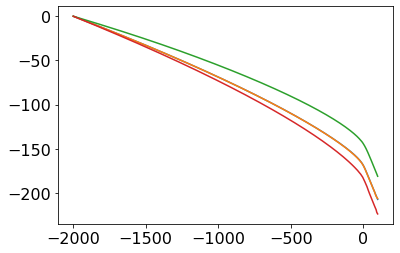

In [40]:
plt.figure()
for name in ts.keys():
    plt.plot(common_times, ts[name][-10])

In [41]:
tol = 1e-6

In [42]:
grbs = {}
for name in model_wfs.keys():
    print(f"building basis for {name}")
    grbs.update({name:build_basis(ts[name], times=common_times, tol=tol)})
    print("\n")

building basis for SEOBNRv4_opt

Step 	 Error
1 	 18971328.727170072
2 	 101027.72234190628
3 	 161.87239260412753
4 	 0.4596040789037943
5 	 0.021202923730015755
6 	 0.004657212644815445
7 	 6.110034883022308e-05
8 	 3.588944673538208e-05
9 	 8.58306884765625e-06
10 	 5.392357707023621e-06
11 	 1.6596168279647827e-06
12 	 1.169741153717041e-06
13 	 7.338821887969971e-07


building basis for IMRPhenomD

Step 	 Error
1 	 19021488.06770914
2 	 101018.09134965017
3 	 166.35053163208067
4 	 3.721049077808857
5 	 1.0253255739808083
6 	 0.45954197458922863
7 	 0.19781002774834633
8 	 0.07594121433794498
9 	 0.03438959829509258
10 	 0.011257931590080261
11 	 0.005739100277423859
12 	 0.003246026113629341
13 	 0.001198234036564827
14 	 0.0003664530813694
15 	 0.0003138035535812378
16 	 0.00018154829740524292
17 	 0.00015077926218509674
18 	 5.389750003814697e-05
19 	 5.056336522102356e-05
20 	 2.3700296878814697e-05
21 	 1.9377097487449646e-05
22 	 1.5271827578544617e-05
23 	 7.085502147674560

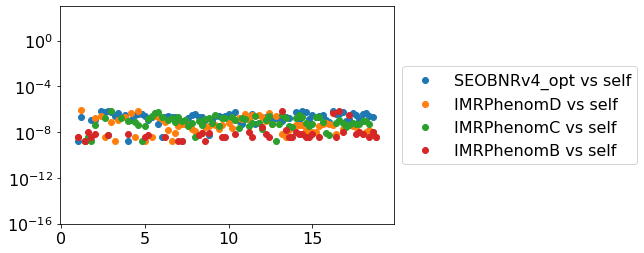

In [43]:
plt.figure()
for name in grbs.keys():
    plt.scatter(q_arr, grbs[name].validate(ts[name]), label=f'{name} vs self')

plt.yscale('log')
plt.ylim(1e-16, 1e3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


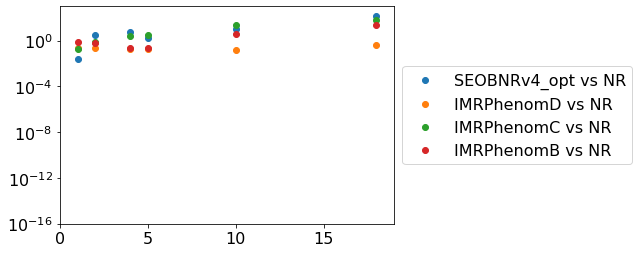

In [44]:
plt.figure()
for name in grbs.keys():
    plt.scatter(nr_q_arr, grbs[name].validate(nr_ts), label=f'{name} vs NR')


plt.yscale('log')
plt.ylim(1e-16, 1e3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## pick a model and enrich

In [45]:
grbs["IMRPhenomD"].enrich(nr_ts, tol=tol)


Step 	 Error
0 	 0.4307592250406742
1 	 0.2540854848921299
2 	 0.08881520852446556
3 	 0.03857657127082348
4 	 0.012817773967981339
5 	 0.0070579200983047485


Text(0.5, 1.0, 'modelA basis')

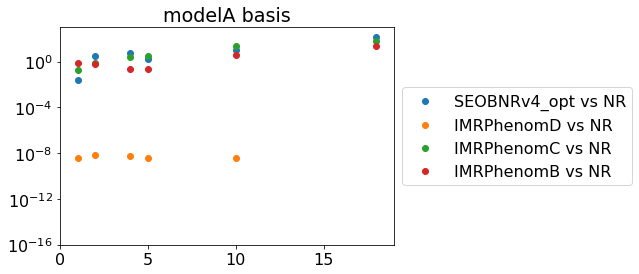

In [46]:
plt.figure()
for name in grbs.keys():
    plt.scatter(nr_q_arr, np.abs(grbs[name].validate(nr_ts)), label=f'{name} vs NR')


plt.yscale('log')
plt.ylim(1e-16, 1e3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("modelA basis")

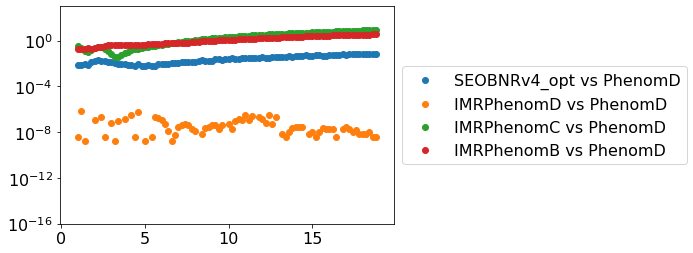

In [47]:
plt.figure()
for name in grbs.keys():
    plt.scatter(q_arr, grbs["IMRPhenomD"].validate(ts[name]), label=f'{name} vs PhenomD')

plt.yscale('log')
plt.ylim(1e-16, 1e3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [48]:
match(ts["IMRPhenomD"][0], ts["IMRPhenomD"][0], common_times)

0.9999999999999993

In [49]:
match(ts["IMRPhenomD"][-10], ts["IMRPhenomC"][-10], common_times)

0.9997220597016433

In [50]:
q_arr

array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
        3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.2,
        5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,
        7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,
        9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8,
       12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. ,
       14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2,
       16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4,
       18.6, 18.8])

In [51]:
nr_q_arr

array([ 1.,  2.,  4.,  5., 10., 18.])

In [52]:
for name in ts.keys():
    print(f"{name}: {match(ts[name][-5], nr_ts[-1], common_times)}")

SEOBNRv4_opt: 0.9999898261937359
IMRPhenomD: 0.9999903465983223
IMRPhenomC: 0.9996349998297372
IMRPhenomB: 0.9999546750699826


In [53]:
grbs["IMRPhenomD"].basis

array([[ 0.00000000e+00, -2.82627856e-05, -5.65360200e-05, ...,
        -5.71360142e-02, -5.74552105e-02, -5.77511638e-02],
       [ 0.00000000e+00, -4.14471762e-05, -8.28721675e-05, ...,
         1.27497403e-01,  1.30459706e-01,  1.33344774e-01],
       [ 0.00000000e+00,  7.63593825e-05,  1.52722740e-04, ...,
         1.08295288e-01,  1.22047995e-01,  1.33653105e-01],
       ...,
       [ 0.00000000e+00, -6.30851440e-04, -1.12041063e-03, ...,
         5.21245996e-04, -2.87928015e-04, -3.32657348e-04],
       [ 0.00000000e+00,  3.03060028e-04,  6.99005545e-04, ...,
        -9.09290903e-04, -1.37745264e-04,  1.61991160e-06],
       [ 0.00000000e+00, -3.04474828e-04, -7.61721972e-04, ...,
         3.47213615e-03, -2.58658755e-03, -3.81383316e-04]])

In [57]:
res_ij = np.zeros(shape=(grbs["IMRPhenomD"].size,grbs["IMRPhenomD"].size))
for i in range(grbs["IMRPhenomD"].size):
    for j in range(grbs["IMRPhenomD"].size):
        res_ij[i,j] = integration.dot(grbs["IMRPhenomD"].basis[i], grbs["IMRPhenomD"].basis[j])

In [59]:
np.diag(res_ij)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [64]:
print(res_ij[-5:, -5:])

[[ 1.00000000e+00 -3.46944695e-18 -1.56125113e-17 -2.08166817e-17
   0.00000000e+00]
 [-3.46944695e-18  1.00000000e+00 -1.73472348e-18  2.94902991e-17
  -2.08166817e-17]
 [-1.56125113e-17 -1.73472348e-18  1.00000000e+00 -1.04083409e-17
   2.25514052e-17]
 [-2.08166817e-17  2.94902991e-17 -1.04083409e-17  1.00000000e+00
  -6.07153217e-18]
 [ 0.00000000e+00 -2.08166817e-17  2.25514052e-17 -6.07153217e-18
   1.00000000e+00]]
